# EDA & Preprocessing

In [7]:
import json, io, os
from PIL import Image
from tqdm import tqdm
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import sagemaker
import requests, boto3

In [5]:
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::398227516224:role/service-role/AmazonSageMaker-ExecutionRole-20250620T160865


## 📁 Annotation File Management

We download the Caltech Camera Traps annotation files from a public Google Cloud bucket. These include:
- Category labels (`caltech_camera_traps.json.zip`)
- Bounding box data (`caltech_bboxes_20200316.json`)
- Dataset split definitions (`CaltechCameraTrapsSplits_v0.json`)

These files are then uploaded to our own S3 bucket for future access and processing within AWS infrastructure.


In [5]:
# Annotations
files = {
    "caltech_camera_traps.json.zip": "https://storage.googleapis.com/public-datasets-lila/caltechcameratraps/labels/caltech_camera_traps.json.zip",
    "caltech_bboxes_20200316.json": "https://storage.googleapis.com/public-datasets-lila/caltechcameratraps/labels/caltech_bboxes_20200316.json",
    "CaltechCameraTrapsSplits_v0.json": "https://storage.googleapis.com/public-datasets-lila/caltechcameratraps/CaltechCameraTrapsSplits_v0.json"
}

# S3 setup
s3 = boto3.client('s3')
bucket_name = 'wildscan-camera-data-new' # Updated to a personal AWS bucket due to lab account resource limitations ('aai-540-data')
s3_prefix = 'annotations/'

for filename, url in files.items():
    print(f"📥 Downloading {filename}...")
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"✅ Saved {filename} locally")

    s3_key = s3_prefix + filename
    s3.upload_file(filename, bucket_name, s3_key)
    print(f"🚀 Uploaded to s3://{bucket_name}/{s3_key}\n")

print("All files downloaded and uploaded successfully.")

📥 Downloading caltech_camera_traps.json.zip...
✅ Saved caltech_camera_traps.json.zip locally
🚀 Uploaded to s3://wildscan-camera-data-new/annotations/caltech_camera_traps.json.zip

📥 Downloading caltech_bboxes_20200316.json...
✅ Saved caltech_bboxes_20200316.json locally
🚀 Uploaded to s3://wildscan-camera-data-new/annotations/caltech_bboxes_20200316.json

📥 Downloading CaltechCameraTrapsSplits_v0.json...
✅ Saved CaltechCameraTrapsSplits_v0.json locally
🚀 Uploaded to s3://wildscan-camera-data-new/annotations/CaltechCameraTrapsSplits_v0.json

🎉 All files downloaded and uploaded successfully.


## Wildlife Image Preprocessing

The image preprocessing step includes:
- Loading each image from the public Caltech Camera Traps S3 bucket
- Extracting bounding box regions
- Cropping and resizing each object to 224x224 pixels
- Uploading both cropped and resized versions back to S3

This prepares the data for downstream model training (e.g., classification or object detection) in a standardized format.

In [ ]:
# Setup
source_s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
source_bucket = 'us-west-2.opendata.source.coop'
source_prefix = 'agentmorris/lila-wildlife/caltech-unzipped/cct_images/'

# Project 
dest_s3 = boto3.client('s3')
dest_bucket = 'wildscan-camera-data-new'
cropped_prefix = 'cct_cropped/'
resized_prefix = 'cct_resized/'

# --- Load annotations ---
def load_annotations(path):
    with open(path) as f:
        data = json.load(f)

    category_lookup = {cat["id"]: cat["name"] for cat in data["categories"]}
    annotations = {}
    for ann in data["annotations"]:
        file_name = ann["image_id"] + ".jpg"
        label = category_lookup.get(ann["category_id"], "unknown")
        annotations.setdefault(file_name, []).append((ann["bbox"], label, ann["category_id"]))
    return annotations

# --- Process one image ---
def process_image(file_name, anns):
    try:
        obj = source_s3.get_object(Bucket=source_bucket, Key=source_prefix + file_name)
        img = Image.open(io.BytesIO(obj['Body'].read())).convert("RGB")
    except Exception as e:
        print(f"Failed to load {file_name}: {e}")
        return 0

    processed = 0
    for i, (bbox, label, _) in enumerate(anns):
        try:
            x, y, w, h = map(int, bbox)
            cropped = img.crop((x, y, x + w, y + h))
            resized = cropped.resize((224, 224))

            filename_base = f"{os.path.splitext(file_name)[0]}_{i}.jpg"

            # Save cropped
            crop_buf = io.BytesIO()
            cropped.save(crop_buf, format='JPEG')
            crop_buf.seek(0)
            dest_s3.upload_fileobj(crop_buf, dest_bucket, cropped_prefix + filename_base)

            # Save resized
            resize_buf = io.BytesIO()
            resized.save(resize_buf, format='JPEG')
            resize_buf.seek(0)
            dest_s3.upload_fileobj(resize_buf, dest_bucket, resized_prefix + filename_base)

            processed += 1
        except Exception as e:
            print(f"Error processing {file_name} bbox {i}: {e}")
    return processed

# --- Main ---
def main():
    annotation_path = 'caltech_bboxes_20200316.json'  # Make sure this is downloaded
    annotations_map = load_annotations(annotation_path)
    total = 0

    for file_name, anns in tqdm(annotations_map.items(), desc="Processing images"):
        total += process_image(file_name, anns)

    print(f"\n Done. Total cropped/resized: {total}")

if __name__ == "__main__":
    main()

In [9]:
import matplotlib.patches as patches

def visualize_preprocessing_sample(file_name, anns):
    # Load original image
    obj = source_s3.get_object(Bucket=source_bucket, Key=source_prefix + file_name)
    img = Image.open(io.BytesIO(obj['Body'].read())).convert("RGB")

    fig, axs = plt.subplots(1, min(3, len(anns) + 1), figsize=(12, 4))

    # Original with bbox
    axs[0].imshow(img)
    axs[0].set_title("Original with BBoxes")
    axs[0].axis('off')

    for bbox, label, _ in anns:
        x, y, w, h = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        axs[0].add_patch(rect)

    # Show first few crops/resized
    for i, (bbox, label, _) in enumerate(anns[:2]):
        x, y, w, h = map(int, bbox)
        cropped = img.crop((x, y, x + w, y + h))
        resized = cropped.resize((224, 224))

        axs[i + 1].imshow(resized)
        axs[i + 1].set_title(f"{label} (Resized)")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

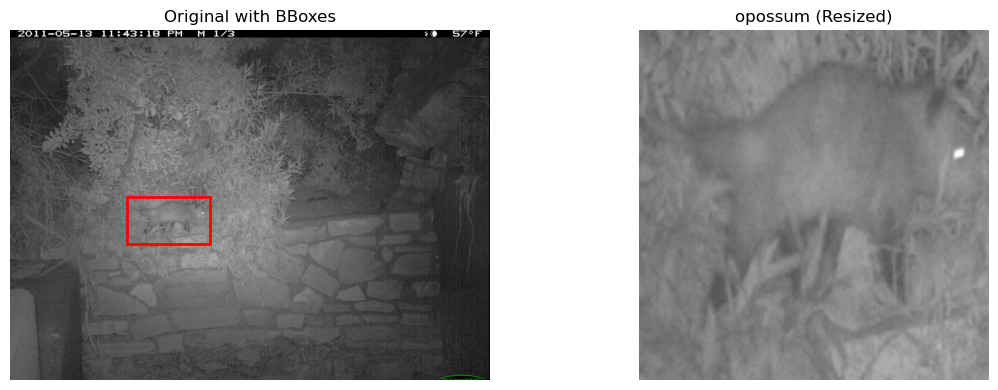

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Re-load annotations into memory (very fast, no downloads)
annotation_path = 'caltech_bboxes_20200316.json'
annotations_map = load_annotations(annotation_path)

# Try a specific example
sample_file = list(annotations_map.keys())[0]
visualize_preprocessing_sample(sample_file, annotations_map[sample_file])

## Bounding Box Verification

To verify preprocessing quality, we visualize a sample image with:
- The original image overlaid with bounding boxes
- The corresponding cropped and resized images

This helps validate bounding box accuracy and image transformation logic.


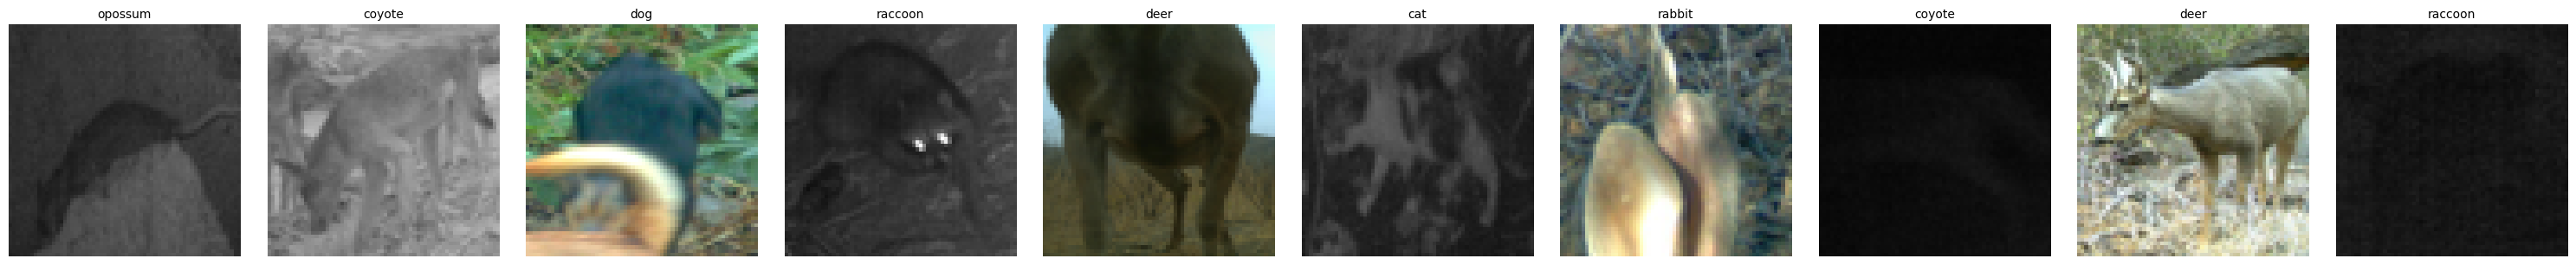

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt

def show_montage_from_s3(num_samples=10):
    sampled = random.sample(list(annotations_map.items()), num_samples)
    fig, axs = plt.subplots(1, num_samples, figsize=(3 * num_samples, 3))

    for i, (file_name, anns) in enumerate(sampled):
        try:
            obj = source_s3.get_object(Bucket=source_bucket, Key=source_prefix + file_name)
            img = Image.open(io.BytesIO(obj['Body'].read())).convert("RGB")
            bbox, label, _ = anns[0]  # just the first object
            x, y, w, h = map(int, bbox)
            cropped = img.crop((x, y, x + w, y + h)).resize((64, 64))

            axs[i].imshow(cropped)
            axs[i].set_title(label, fontsize=10)
            axs[i].axis('off')
        except Exception as e:
            print(f"Skipping {file_name}: {e}")
            axs[i].axis('off')
            axs[i].set_title("Error")

    plt.tight_layout()
    plt.show()

show_montage_from_s3(10)

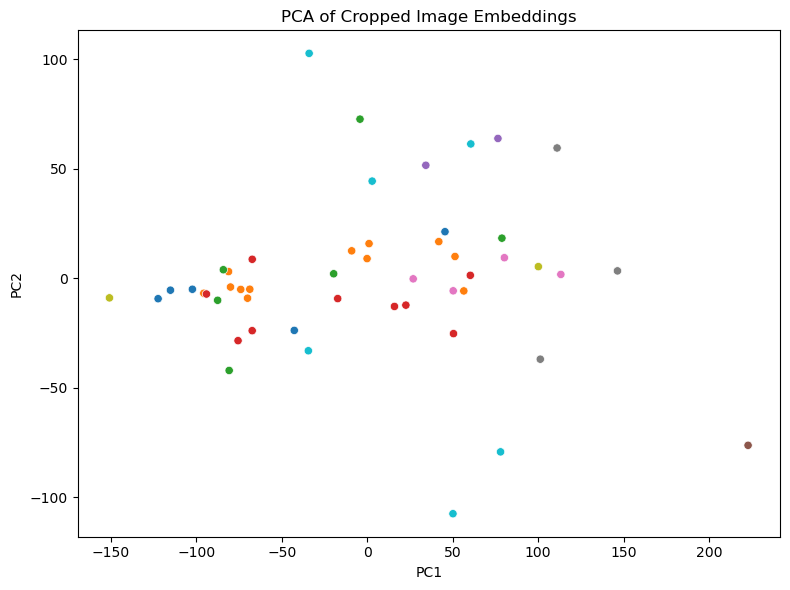

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

def run_pca_on_crops(sample_size=50):
    image_vectors = []
    labels = []

    sampled = random.sample(list(annotations_map.items()), sample_size)

    for file_name, anns in sampled:
        try:
            obj = source_s3.get_object(Bucket=source_bucket, Key=source_prefix + file_name)
            img = Image.open(io.BytesIO(obj['Body'].read())).convert("RGB")
            for bbox, label, _ in anns[:1]:  # just one object per image
                x, y, w, h = map(int, bbox)
                cropped = img.crop((x, y, x + w, y + h)).resize((64, 64))
                image_vectors.append(np.array(cropped).flatten())
                labels.append(label)
        except Exception as e:
            continue

    image_vectors = np.array(image_vectors)
    scaler = StandardScaler()
    image_vectors_scaled = scaler.fit_transform(image_vectors)

    pca = PCA(n_components=2)
    components = pca.fit_transform(image_vectors_scaled)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=labels, palette='tab10', legend=False)
    plt.title("PCA of Cropped Image Embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

run_pca_on_crops(50)


## PCA of Cropped Image Pixel Vectors

To explore the separability of different animal categories, we flatten the cropped image pixels and apply Principal Component Analysis (PCA) to reduce them to 2D space.

This projection can give us insights into:
- Whether certain categories cluster naturally based on pixel values
- How noisy or overlapping the class boundaries might be before training


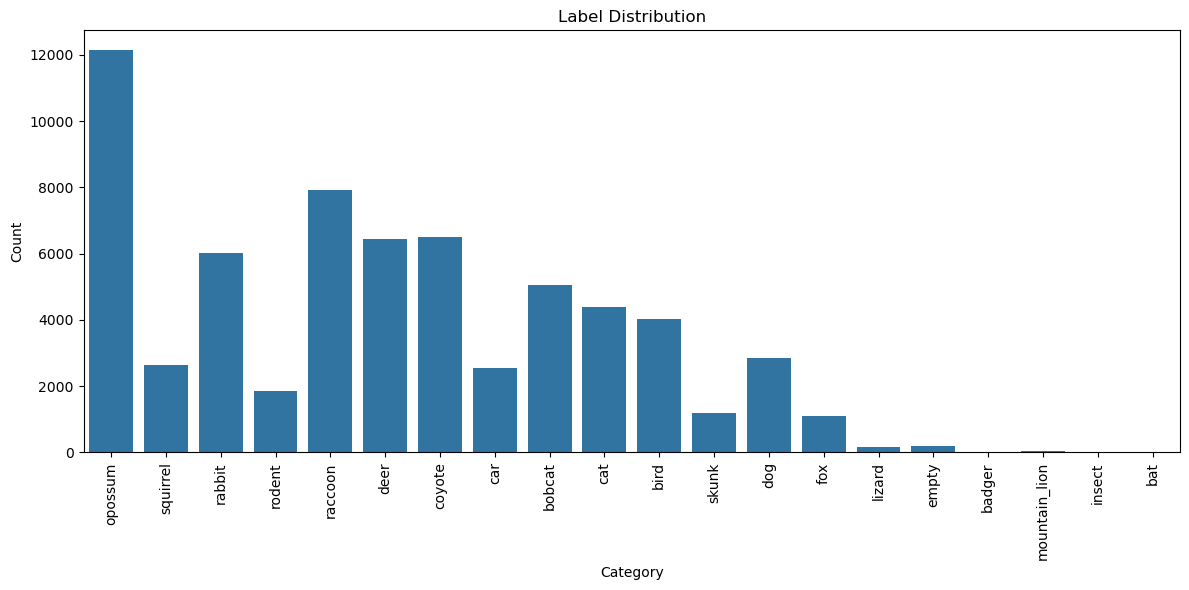

In [13]:
from collections import Counter
import seaborn as sns

labels = [label for anns in annotations_map.values() for _, label, _ in anns]
label_counts = Counter(labels)

plt.figure(figsize=(12,6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.xticks(rotation=90)
plt.title("Label Distribution")
plt.ylabel("Count")
plt.xlabel("Category")
plt.tight_layout()
plt.show()

## Label Distribution Insights

The bar chart above shows the distribution of detected objects (animal categories) in the Caltech Camera Traps dataset.

### Key Observations:
- **Opossums** dominate the dataset, with over 12,000 labeled instances, followed by **raccoons**, **deer**, and **coyotes**.
- There's a noticeable class imbalance — categories like **bat**, **insect**, **mountain_lion**, and **badger** have very few examples.
- A few **non-animal categories** like "car" and "empty" are also present, which may represent false triggers or additional context data.
- **Rare classes** could present challenges during model training due to insufficient examples, potentially requiring techniques like:
  - Data augmentation
  - Class re-weighting
  - Oversampling / undersampling
  - Few-shot learning (in later stages)

Understanding this distribution helps inform downstream decisions like stratified sampling, validation split design, and model evaluation strategies.


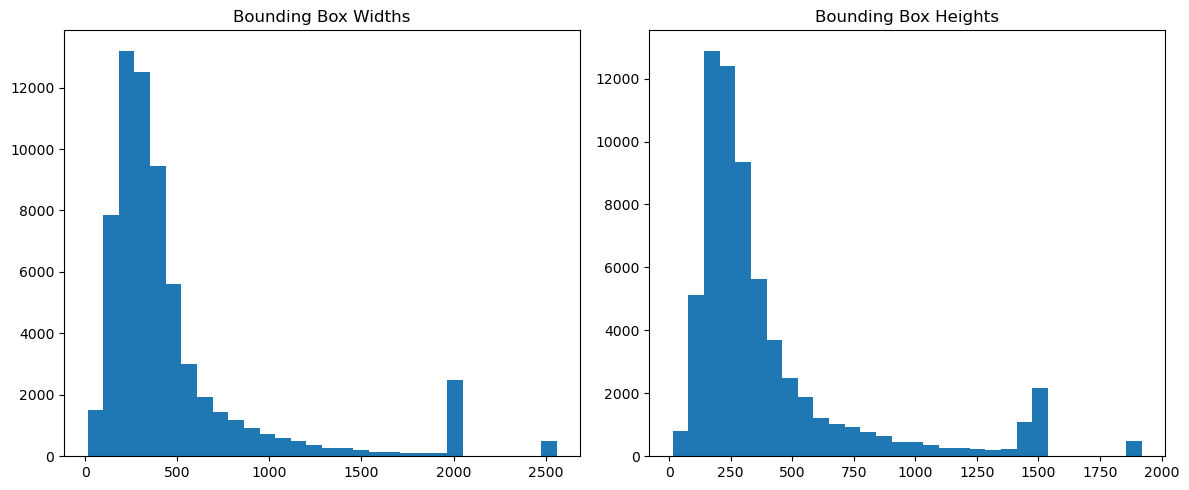

In [14]:
widths = []
heights = []

for anns in annotations_map.values():
    for bbox, _, _ in anns:
        w, h = bbox[2], bbox[3]
        widths.append(w)
        heights.append(h)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30)
plt.title('Bounding Box Widths')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30)
plt.title('Bounding Box Heights')
plt.tight_layout()
plt.show()


## Bounding Box Dimensions

The histograms above display the distribution of **bounding box widths** and **heights** across all annotated objects in the dataset.

### Observations:
- Most bounding boxes are **relatively small**, with a large concentration of widths and heights under **500 pixels**.
- The distributions are **right-skewed**, indicating a long tail of larger objects.
- A small number of bounding boxes exceed **1000+ pixels**, which may correspond to:
  - Very close-range captures
  - Large animals like deer or mountain lions
  - Misannotations or overlapping bounding boxes
- Notable spikes at exact values (e.g., 2000px width/height) could suggest **annotation artifacts** or fixed bounding box defaults in some cases.

### Why This Matters:
- Understanding size distribution is important for:
  - **Choosing image resize parameters** (e.g., 224x224) that preserve object details
  - Designing detection models that handle **scale variance**
  - Detecting and cleaning possible annotation errors

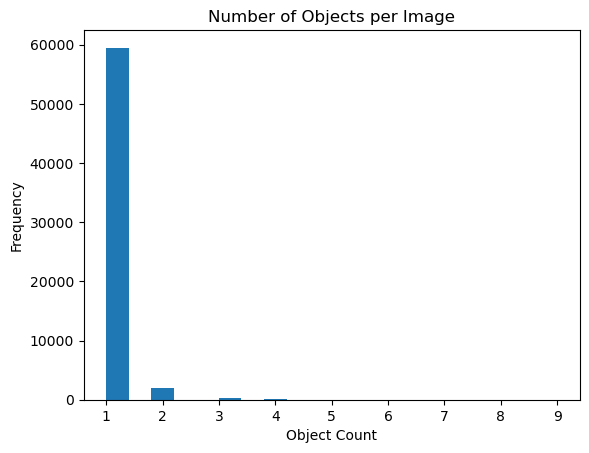

In [15]:
objects_per_image = [len(anns) for anns in annotations_map.values()]
plt.hist(objects_per_image, bins=20)
plt.title('Number of Objects per Image')
plt.xlabel('Object Count')
plt.ylabel('Frequency')
plt.show()

## Number of Objects per Image

The histogram above shows how many labeled objects are present per image in the dataset.

### Observations:
- **Most images contain a single object**, with over 60,000 images annotated with only one bounding box.
- A small percentage of images contain **multiple objects**, with a sharp drop-off as the object count increases.
- The maximum number of objects in a single image is around 9, but this is extremely rare.

### Implications:
- The dataset is **heavily dominated by single-object images**, which simplifies the preprocessing and training pipeline (especially for classification tasks).
- For object detection models, this skew should be considered when:
  - Evaluating multi-object prediction accuracy
  - Designing augmentations (e.g., simulated crowd scenes)
  - Sampling validation sets to ensure some images with multiple objects are included

## Summary of Preprocessing and Exploratory Data Analysis

This notebook walks through the complete preprocessing pipeline and data exploration for the Caltech Camera Traps dataset. Below is a summary of key steps and insights:

### Preprocessing Pipeline
- Downloaded official annotations and dataset split files
- Uploaded raw annotation files to a dedicated S3 bucket for versioned access
- Parsed bounding boxes and category labels for each image
- Cropped individual animal instances from original images using bounding boxes
- Resized crops to 224×224 pixels (suitable for most CNN-based architectures)
- Uploaded both cropped and resized images to S3 in organized prefixes
- Verified pipeline correctness through side-by-side visualizations of:
  - Original image with bounding boxes
  - Resized crops of detected objects

### Exploratory Data Analysis
- **Label distribution:** Significant class imbalance observed; 'opossum', 'raccoon', and 'deer' dominate the dataset
- **Bounding box sizes:** Most bounding boxes are small; skewed distribution with outliers over 1000 pixels
- **Object density:** Over 90% of images contain only one annotated object, which simplifies modeling
- **Sample montage:** Verified quality and variability of cropped/resized objects
- **PCA visualization:** Initial 2D projection shows some class structure based on pixel data, useful for intuition building

### Outcome
The dataset is now:
- Preprocessed and stored in an accessible S3 structure
- Well-understood through EDA for both size distribution and class balance
- Ready for use in image classification or object detection models, with actionable insights to inform modeling strategies (e.g., handling class imbalance, augmentation design)
